In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import os
import cv2
from PIL import Image
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-12-28 16:27:08.032502: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 16:27:08.059259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-28 16:27:08.059293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-28 16:27:08.060086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 16:27:08.064998: I tensorflow/core/platform/cpu_feature_guar

##### Verstappen vs Leclerc

In [2]:
class preprocess:
    def __init__(self, path):
        self.path = path
        self.dir_list = os.listdir(path)
        self.img = np.empty((1,0))
        self.label = np.empty((1,0))
        self.target_size=None

        self.x_train = []
        self.y_train = []
        self.x_val = []
        self.y_val = []
        self.x_test = []
        self.y_test = []
        print(f"dir_list: {self.dir_list}")

    def show_shape(self):
        print(f"x_train shape: {self.x_train.shape}")
        print(f"x_val shape: {self.x_val.shape}")
        print(f"x_test shape: {self.x_test.shape}")
        print(f"y_train shape: {self.y_train.shape}")
        print(f"y_val shape: {self.y_val.shape}")
        print(f"y_test shape: {self.y_test.shape}")

    def load_data(self, targetsize):
        self.target_size =  targetsize

        for dir in self.dir_list:

            imgs_list = os.listdir(self.path+'/'+dir)
            img_num = len(imgs_list)
            print(img_num)

            for img in imgs_list:
                train_ratio = img_num * 0.7
                val_ratio = img_num * 0.23

                name = (re.findall('[a-z]+', img)[0])
                num = int(re.findall('\d+', img)[0])
                
                img_to_convert = Image.open(self.path+'/'+dir+'/'+img)
                img_array = np.array(img_to_convert)
                img_array = img_array[:,:,:3]
                img_array_resized = cv2.resize(img_array, self.target_size)

                # train set
                if 1 <= num <= train_ratio:
                    self.x_train.append(img_array_resized)
                    if name == "leclerc":
                        self.y_train.append(0)
                    elif name == "ver":
                        self.y_train.append(1)

                # train_validation set
                elif train_ratio <= num <= train_ratio+val_ratio:
                    self.x_val.append(img_array_resized)
                    if name == "leclerc":
                        self.y_val.append(0)
                    elif name == "ver":
                        self.y_val.append(1)

                # eval_validation set
                elif train_ratio+val_ratio <= num <= img_num:
                    self.x_test.append(img_array_resized)
                    if name == "leclerc":
                        self.y_test.append(0)
                    elif name == "ver":
                        self.y_test.append(1)

        # one-hot encoding
        self.y_train = tf.keras.utils.to_categorical(self.y_train, 2)
        self.y_val = tf.keras.utils.to_categorical(self.y_val, 2)
        self.y_test = tf.keras.utils.to_categorical(self.y_test, 2)

        self.x_train = np.array(self.x_train)
        self.x_train = self.x_train.astype(np.float32)/255.0
        self.y_train = np.array(self.y_train)
        self.x_val = np.array(self.x_val)
        self.x_val = self.x_val.astype(np.float32)/255.0
        self.y_val = np.array(self.y_val)     
        self.x_test = np.array(self.x_test)
        self.x_test = self.x_test.astype(np.float32)/255.0
        self.y_test = np.array(self.y_test)   

In [3]:
datasets = preprocess("./f1driver")

dir_list: ['verstappen', 'leclerc']


In [4]:
datasets.load_data((128, 128))

55
55


In [5]:
datasets.show_shape()

x_train shape: (76, 128, 128, 3)
x_val shape: (26, 128, 128, 3)
x_test shape: (8, 128, 128, 3)
y_train shape: (76, 2)
y_val shape: (26, 2)
y_test shape: (8, 2)


In [6]:
class CNN_Model:
    def __init__(self, batch_size, epochs, input_shape, optimizer, loss):
        self.model = Sequential()
        self.kernal = (3,3)
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.loss = loss
        self.hist = None
        self.res = None

    def First_Conv_layer(self,filters, kernal, activation):
        self.model.add(Conv2D(filters, kernal, activation=activation, input_shape=self.input_shape))

    def Conv(self, filters, kernal, activation):
        self.model.add(Conv2D(filters, kernal, activation=activation))

    def Pool(self, pool_size):
        self.model.add(MaxPooling2D(pool_size=pool_size))

    def Dense(self, filters, activation):
        self.model.add(Dense(filters, activation=activation))
        
    def Flatten(self):
        self.model.add(Flatten())

    def Dropout(self, ratio):
        self.model.add(Dropout(ratio))

    def compile(self):
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])

    def fit(self, x_train, y_train, x_val, y_val, patience):
        #timestamp = int(time.time())
        #checkpoint=ModelCheckpoint(filepath=f'best_model_weights_{timestamp}.h5', save_weights_only=True, monitor='val_loss', save_best_only=True, verbose=1)
        generator = ImageDataGenerator(rotation_range=30.0, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
        early_stopping = EarlyStopping( monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
        self.hist = self.model.fit(generator.flow(x_train, y_train, batch_size=self.batch_size, shuffle=False), epochs=self.epochs, callbacks=[early_stopping], validation_data=(x_val, y_val), verbose=2)
        print(np.array_equal(x_train, x_val))
    
    def evaluate(self, x_test, y_test):
        self.res = self.model.evaluate(x_test, y_test, verbose=0)
        print(f"acc of this model: {self.res[1]*100:.2f}%")
    

In [7]:
mymodel = CNN_Model(128, 90, datasets.x_train[0].shape, Adam(), 'categorical_crossentropy')

mymodel.First_Conv_layer(32, (3,3), 'relu')
mymodel.Conv(32, (3,3), 'relu')
mymodel.Pool(2)
mymodel.Dropout(0.25)
mymodel.Conv(64, (3,3), 'relu')
mymodel.Conv(128, (3,3), 'relu')
mymodel.Pool(2)
mymodel.Flatten()
mymodel.Dense(32, 'relu')
mymodel.Dropout(0.5)
mymodel.Dense(2, 'softmax')

2024-12-28 16:27:14.862234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-28 16:27:14.952103: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-28 16:27:14.952369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
mymodel.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 128)       73856     
                                                        

In [9]:
mymodel.compile()

In [17]:
mymodel.fit(datasets.x_train, datasets.y_train, datasets.x_val, datasets.y_val, 30)

Epoch 1/90
1/1 - 0s - loss: 0.2818 - accuracy: 0.8684 - val_loss: 0.5989 - val_accuracy: 0.7308 - 235ms/epoch - 235ms/step
Epoch 2/90
1/1 - 0s - loss: 0.3561 - accuracy: 0.8816 - val_loss: 0.7266 - val_accuracy: 0.7308 - 203ms/epoch - 203ms/step
Epoch 3/90
1/1 - 0s - loss: 0.3893 - accuracy: 0.8553 - val_loss: 0.7095 - val_accuracy: 0.7308 - 208ms/epoch - 208ms/step
Epoch 4/90
1/1 - 0s - loss: 0.2967 - accuracy: 0.8553 - val_loss: 0.5577 - val_accuracy: 0.7308 - 218ms/epoch - 218ms/step
Epoch 5/90
1/1 - 0s - loss: 0.2360 - accuracy: 0.9079 - val_loss: 0.4681 - val_accuracy: 0.7692 - 207ms/epoch - 207ms/step
Epoch 6/90
1/1 - 0s - loss: 0.3344 - accuracy: 0.8421 - val_loss: 0.4872 - val_accuracy: 0.7692 - 205ms/epoch - 205ms/step
Epoch 7/90
1/1 - 0s - loss: 0.3449 - accuracy: 0.8816 - val_loss: 0.5617 - val_accuracy: 0.7308 - 207ms/epoch - 207ms/step
Epoch 8/90
1/1 - 0s - loss: 0.2969 - accuracy: 0.9211 - val_loss: 0.5941 - val_accuracy: 0.7308 - 211ms/epoch - 211ms/step
Epoch 9/90
1/1 -

In [18]:
mymodel.evaluate(datasets.x_val, datasets.y_val)

acc of this model: 80.77%


save weights

In [20]:
mymodel.model.load_weights("/home/ms/ws/git_ws/LearningModel/MyNote/CNN_Model/best_model_weights_1735134323.h5")

In [19]:
mymodel.model.save("mymodel1")

INFO:tensorflow:Assets written to: mymodel1/assets


INFO:tensorflow:Assets written to: mymodel1/assets


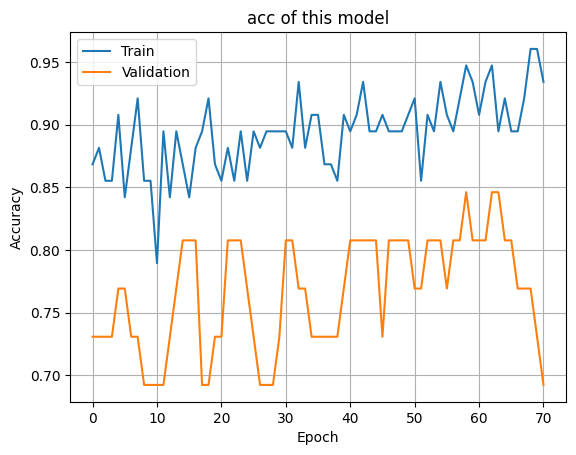

In [19]:
plt.plot(mymodel.hist.history['accuracy'])
plt.plot(mymodel.hist.history['val_accuracy'])
plt.legend(["Train", "Validation"], loc="best")
plt.title("acc of this model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

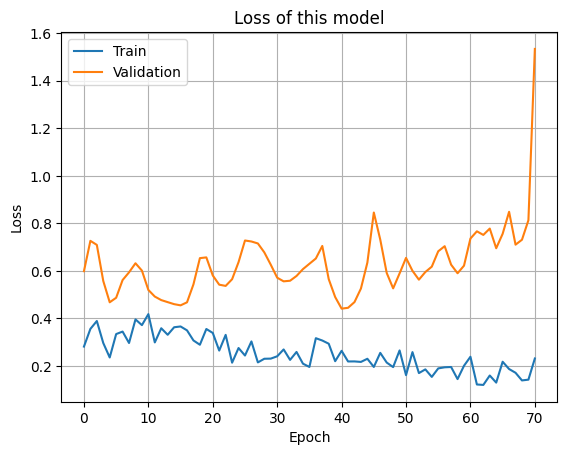

In [20]:
plt.plot(mymodel.hist.history['loss'])
plt.plot(mymodel.hist.history['val_loss'])
plt.legend(["Train", "Validation"], loc="best")
plt.title("Loss of this model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [21]:
def img_into_numpy(path):
    test_list = []
    img_list = os.listdir(path)
    for imgs in img_list:
        img = Image.open(path+'/'+imgs)
        img_array = np.array(img)
        img_array = img_array[:,:,:3]

        img_array = cv2.resize(img_array, (128,128))
        test_list.append(img_array)

    test_list = np.array(test_list)
    print(f"shape of test_data: {test_list.shape}")

    return test_list


In [22]:
test_data = img_into_numpy("./f1driver_test")

shape of test_data: (8, 128, 128, 3)


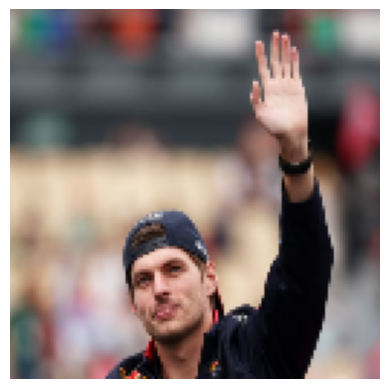

1/1 [==============================] - 0s 13ms/step
Predicted class: 1
Predict possibility: [0. 1.]
It's Max Verstappen!


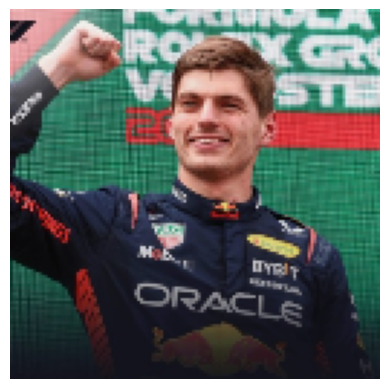

1/1 [==============================] - 0s 12ms/step
Predicted class: 1
Predict possibility: [0. 1.]
It's Max Verstappen!


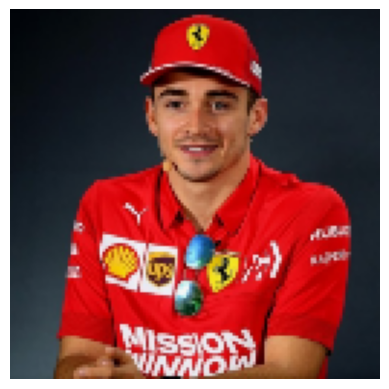

1/1 [==============================] - 0s 11ms/step
Predicted class: 0
Predict possibility: [1. 0.]
It's Charles Leclerc!


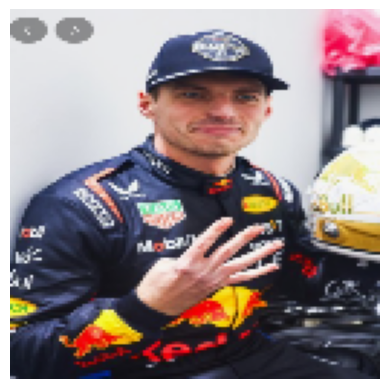

1/1 [==============================] - 0s 13ms/step
Predicted class: 1
Predict possibility: [0. 1.]
It's Max Verstappen!


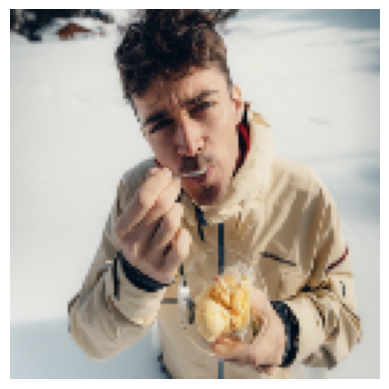

1/1 [==============================] - 0s 16ms/step
Predicted class: 1
Predict possibility: [0. 1.]
It's Max Verstappen!


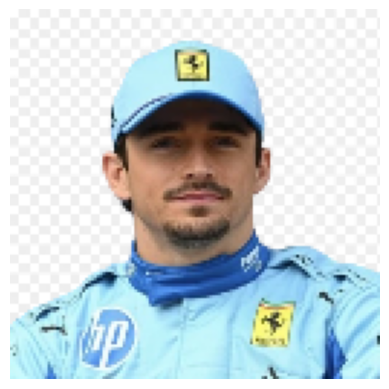

1/1 [==============================] - 0s 11ms/step
Predicted class: 1
Predict possibility: [0. 1.]
It's Max Verstappen!


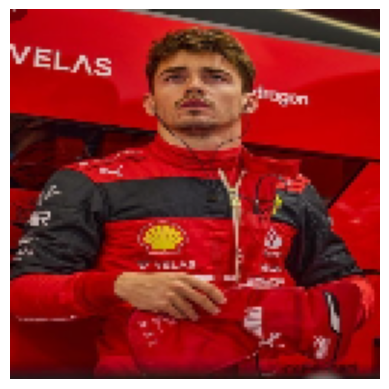

1/1 [==============================] - 0s 14ms/step
Predicted class: 0
Predict possibility: [1. 0.]
It's Charles Leclerc!


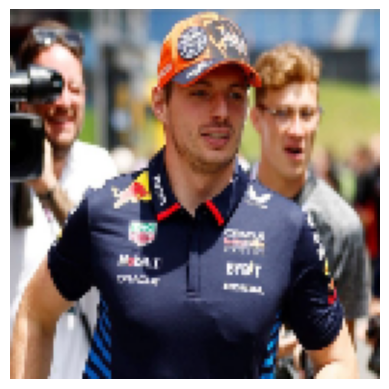

1/1 [==============================] - 0s 15ms/step
Predicted class: 1
Predict possibility: [0. 1.]
It's Max Verstappen!


In [23]:
for each_data in test_data:
    plt.imshow(each_data)
    plt.axis("off")
    plt.show()
    
    # augment array_size (batch_size).
    each_data = np.expand_dims(each_data, axis=0)
    prediction = mymodel.model.predict(each_data)
    print("Predicted class:", prediction[0].argmax())
    print("Predict possibility:", prediction[0])
    if prediction[0].argmax() == 0:
        print("It's Charles Leclerc!")
    elif prediction[0].argmax() == 1:
        print("It's Max Verstappen!")


In [29]:
for layer in mymodel.model.layers:
    if 'conv' in layer.name:
        kernal, biases=layer.get_weights()
        print(f"layer.name: {layer.name}, kernal.shape: {kernal.shape}")

layer.name: conv2d_4, kernal.shape: (3, 3, 3, 32)
layer.name: conv2d_5, kernal.shape: (3, 3, 32, 32)
layer.name: conv2d_6, kernal.shape: (3, 3, 32, 64)
layer.name: conv2d_7, kernal.shape: (3, 3, 64, 128)


In [30]:
kernal, biases = mymodel.model.layers[0].get_weights()
minv, maxv = kernal.min(), kernal.max()
kernel = (kernal-minv)/(maxv-minv)
n_kernel=32

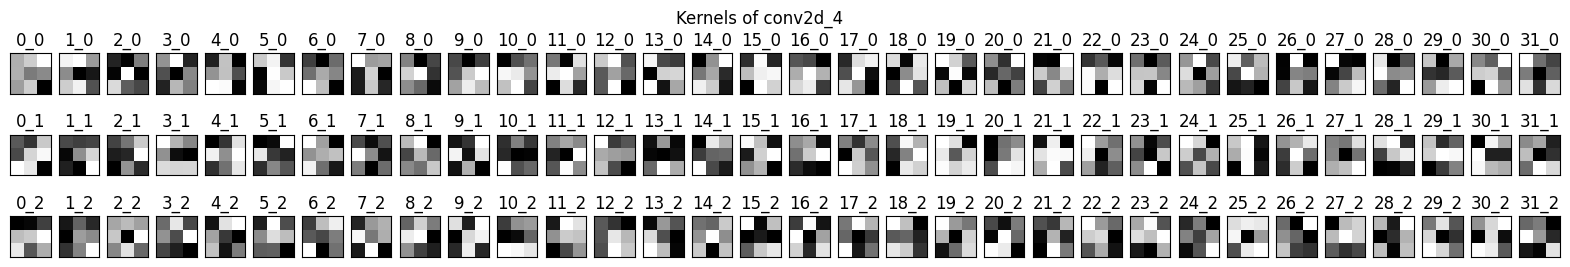

In [31]:
plt.figure(figsize=(20, 3))
plt.suptitle("Kernels of conv2d_4")
for i in range(n_kernel):
    f = kernel[:, :, :, i]
    for j in range(3):
        plt.subplot(3, n_kernel, j*n_kernel+i+1)
        plt.imshow(f[:,:,j], cmap="gray")
        plt.xticks([]); plt.yticks([])
        plt.title(str(i)+'_'+str(j))

plt.show()

In [32]:
for layer in mymodel.model.layers:
    if 'conv' in layer.name:
        print(layer.name, layer.output.shape)

conv2d_4 (None, 126, 126, 32)
conv2d_5 (None, 124, 124, 32)
conv2d_6 (None, 60, 60, 64)
conv2d_7 (None, 58, 58, 128)


In [35]:
partial_model = Model(inputs = mymodel.model.inputs, outputs = mymodel.model.layers[0].output)
partial_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer  [(None, 128, 128, 3)]     0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
Total params: 896 (3.50 KB)
Trainable params: 896 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
feature_map = partial_model.predict(datasets.x_test)
fm = feature_map[1]

1/1 [==============================] - 0s 16ms/step


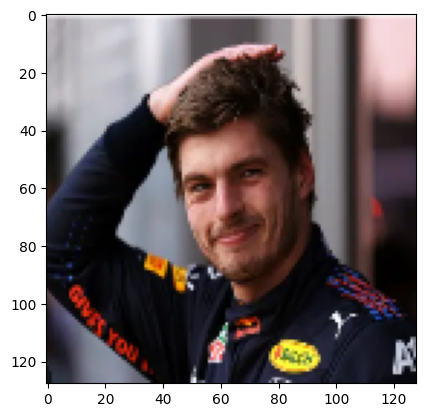

In [45]:
plt.imshow(datasets.x_test[1])

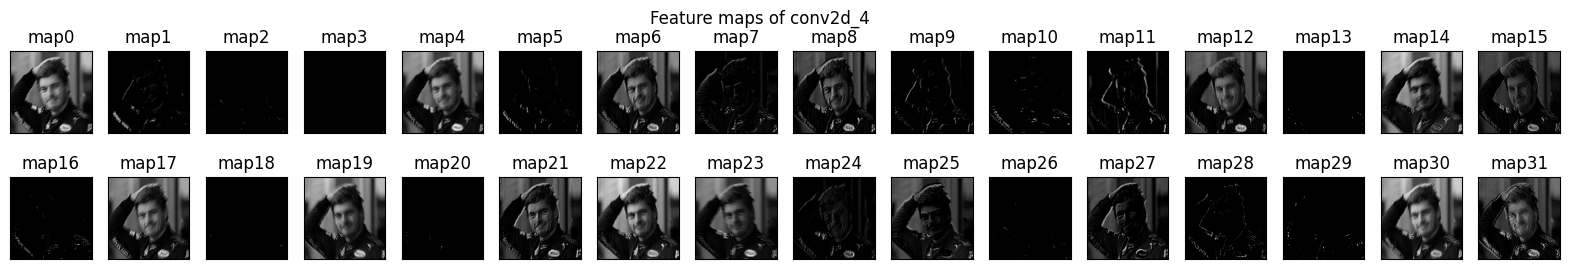

In [46]:
plt.figure(figsize=(20, 3))
plt.suptitle("Feature maps of conv2d_4")
for i in range(32):
    plt.subplot(2, 16, i+1)
    plt.imshow(fm[:,:,i], cmap="gray")
    plt.xticks([]); plt.yticks([])
    plt.title("map"+str(i))
plt.show()

In [47]:
feature_map2 = partial_model.predict(test_data)
fm2 = feature_map2[2]

1/1 [==============================] - 0s 14ms/step


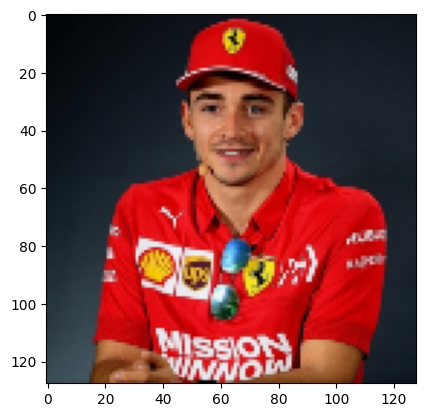

In [48]:
plt.imshow(test_data[2])

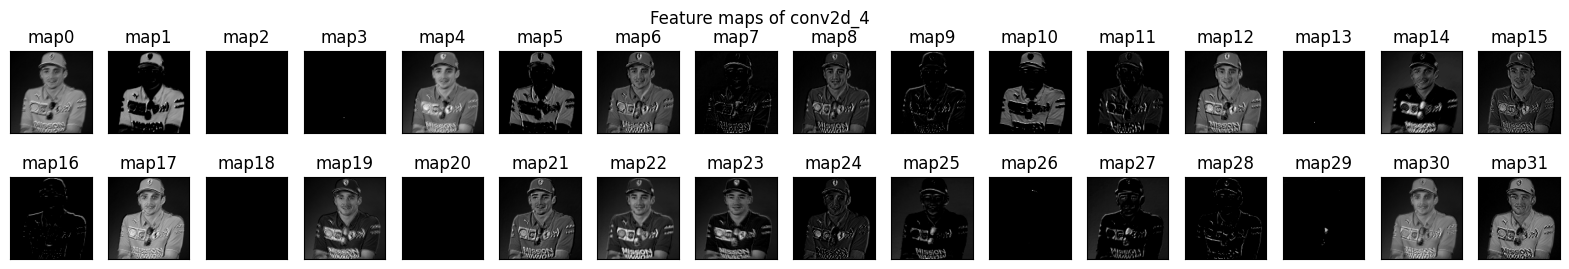

In [49]:
plt.figure(figsize=(20, 3))
plt.suptitle("Feature maps of conv2d_4")
for i in range(32):
    plt.subplot(2, 16, i+1)
    plt.imshow(fm2[:,:,i], cmap="gray")
    plt.xticks([]); plt.yticks([])
    plt.title("map"+str(i))
plt.show()

In [50]:
feature_map3 = partial_model.predict(test_data)
fm3 = feature_map2[5]

1/1 [==============================] - 0s 14ms/step


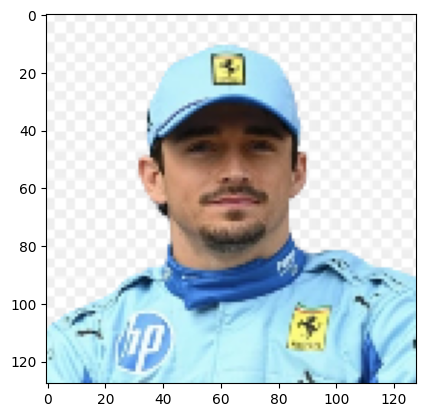

In [51]:
plt.imshow(test_data[5])

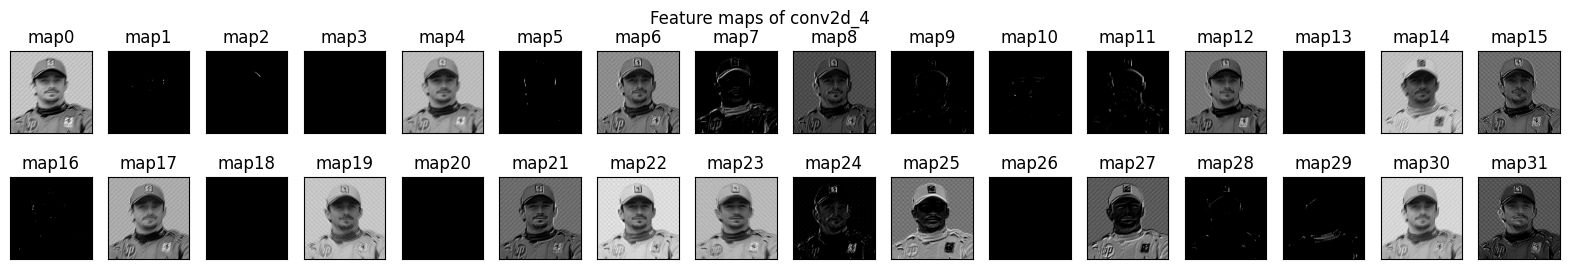

In [52]:
plt.figure(figsize=(20, 3))
plt.suptitle("Feature maps of conv2d_4")
for i in range(32):
    plt.subplot(2, 16, i+1)
    plt.imshow(fm3[:,:,i], cmap="gray")
    plt.xticks([]); plt.yticks([])
    plt.title("map"+str(i))
plt.show()

When you get an error like 'GPU EXHAUSTED'

In [22]:
from numba import cuda

device = cuda.get_current_device()
device.reset()